In [1]:
import sys

sys.path.append('/Users/robertwelch/Desktop/BIIF/Chiara3/ChiaraNewUpdates/Federico-Pietrocola2022-3/src')

from senolysis_analysis import *
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label

In [2]:
def plot_multi(img_list):

    if isinstance(img_list,list):
        n = len(img_list)

        fig,ax = plt.subplots(1,n)
        fig.set_size_inches(15,15)

        for i,img in enumerate(img_list):
            ax[i].imshow(img,cmap='gray')
    else:
        raise Exception('Input is not a list of images')

# def determine_nuclei_type(mask, red, green, blue):

#     nuclei_regions = regionprops(label(mask))

#     scenescent = np.zeros(mask.shape)
#     quiescent = np.zeros(mask.shape)
#     for nuclei in nuclei_regions:
#         nuclei_coordinates = nuclei.coords
#         red_value = np.mean(red[tuple(nuclei_coordinates.T)])
#         green_value = np.mean(green[tuple(nuclei_coordinates.T)])
#         blue_value = np.mean(blue[tuple(nuclei_coordinates.T)])


#         if red_value > 0.1:
#              scenescent[tuple(nuclei_coordinates.T)] = 1
#         # else:
#         #     quiescent[tuple(nuclei_coordinates.T)] = 1
#         print(red_value)
    

#     return np.bool_(scenescent), np.bool_(quiescent)

In [212]:
def find_intensities(mask,red_downscaled,green_downscaled,blue_downscaled):

    nuclei_scenenst = regionprops(label(mask),intensity_image=red_downscaled)
    nuclei_quiescent = regionprops(label(mask),intensity_image=green_downscaled)
    nuclei_regions = regionprops(label(mask),intensity_image=blue_downscaled)

    red_intensities = []
    green_intensities = []
    nuclei_intentisies = []
    nuclei_size = []
    for i in range(len(nuclei_quiescent)):
        red_intensities.append(nuclei_scenenst[i].mean_intensity)
        green_intensities.append(nuclei_quiescent[i].mean_intensity)
        nuclei_intentisies.append(nuclei_regions[i].mean_intensity)
        nuclei_size.append(nuclei_regions[i].area)



    red_intensities = np.array(red_intensities)
    green_intensities = np.array(green_intensities)

    X = np.zeros([len(green_intensities),4])
    X[:,0] = red_intensities
    X[:,1] = green_intensities
    X[:,2] = nuclei_intentisies
    X[:,3] = nuclei_size
    
    #Normalize for each image
    X = X/X.max(axis=0)

    return X

In [213]:
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/All Images/WellB03_Channel Kinetix Single band tdTomato, Kinetix Single band senolysis  EGFP1, Kinetix Single  Hoechst_Seq0001.nd2'

def main(img_path):
    
    red, green, blue = nd2_import(img_path)


    def remove_well_rings(img,min_size=20000,max_size = 300):
        from skimage.filters import threshold_mean
        from skimage.morphology import remove_small_objects

        thresh = threshold_mean(img)
        binary = img > thresh
        regions = regionprops(label(binary))
        # Generate inverted mask of regions falling between the low_size and min_size
        removal_mask = np.ones(img.shape, dtype="bool")
        for region in regions:
            if max_size < region.area:
                removal_mask[tuple(region.coords.T.tolist())] = 0

        # Used to remove corners of images which sometimes remain
        removal_mask = remove_small_objects(removal_mask, min_size=min_size) #was 20000

        out = removal_mask * img
        return out



    # normalize to [0,1] for 0 to 99th percentiles
    red_norm, green_norm, blue_norm = (
        normalize_img(red, high_per=98),
        normalize_img(green, high_per=98),
        normalize_img(blue, high_per=98),
    )

    # downscale the images for faster computation
    downscale_factor = 4
    blue_downscaled = downscale_local_mean(
        blue_norm, factors=(downscale_factor, downscale_factor)
    )
    green_downscaled = downscale_local_mean(
        green_norm, factors=(downscale_factor, downscale_factor)
    )
    red_downscaled = downscale_local_mean(
        red_norm, factors=(downscale_factor, downscale_factor)
    )

    # Smooth the blue channel for nuclei segmentation
    blue_smoothed = gaussian(blue_downscaled, 1)  # smooth image

    # remove the well ring from the blue channel
    blue_no_well_ring = remove_well_rings(blue_smoothed)

    nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)

    # Segment nuclei in blue channel and clean up results
    nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)
    disk_factor = int(5 / downscale_factor)
    nuclei_thresholded = binary_opening(nuclei_thresholded, footprint=disk(disk_factor))
    nuclei_thresholded = remove_small_holes(nuclei_thresholded, area_threshold=500)
    nuclei_thresholded = remove_large_nuclei(
        nuclei_thresholded, max_size=int(7000 / downscale_factor**2)
    )

    nuclei_thresholded_upscaled = resize(nuclei_thresholded, output_shape=blue.shape)

    # # Determine if each nuclei belongs to scenescent or quiescent cell
    # scenescent_downscaled, quiescent_downscaled = determine_nuclei_type(
    #     mask=nuclei_thresholded,
    #     red=red_downscaled,
    #     green=green_downscaled,
    #     blue=blue_downscaled,
    # )

    # # Upsample segmentation results back to orignal image size
    # scenescent_upscaled = resize(scenescent_downscaled, output_shape=blue.shape)
    # quiescent_upscaled = resize(quiescent_downscaled, output_shape=blue.shape)

    # #Remove any nuclei smaller than 150 pixels
    # scenescent_upscaled = remove_small_objects(scenescent_upscaled,min_size=150)
    # quiescent_upscaled = remove_small_objects(quiescent_upscaled,min_size=150)

    # # Measures counts and nuclei mean size + std
    # results_dataframe = analyze_nuclei(
    #     scenescent_upscaled, quiescent_upscaled, img_path
    # )

    #X = find_intensities(nuclei_thresholded,red_downscaled,green_downscaled,blue_downscaled)
    X = find_intensities(nuclei_thresholded_upscaled,red,green,blue)


    return X


In [214]:
img_paths = find_images('/Users/robertwelch/Desktop/BIIF/Chiara3/All Images')

all_X = []
for img_path in img_paths:

    X = main(img_path)

    all_X.append(X)
    print(len(all_X))

all_X = np.concatenate(all_X)


1
2
3
4
5
6
7
8
9
10


Text(0.5, 0, 'red Intensities')

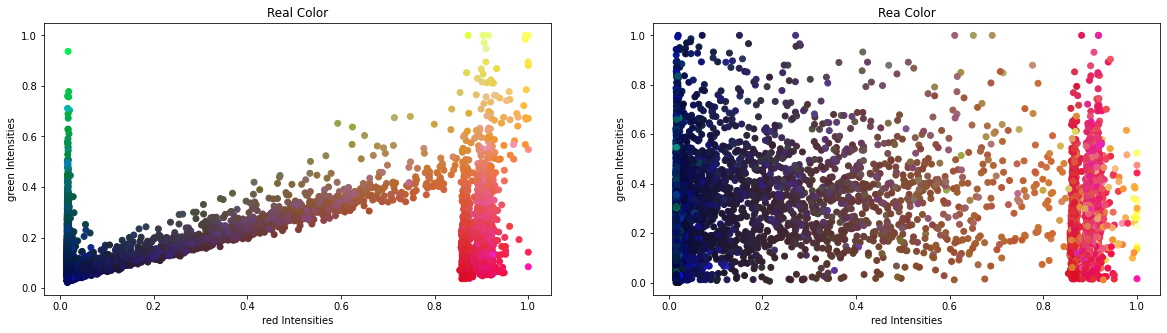

In [233]:
# def get_nuclei_fluorescent_intensities(mask, red, green):

kmeans = KMeans(n_clusters=5, random_state=0).fit(all_X[:,:1])

relative_intensity = all_X[:,0]/all_X[:,1]


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Real Color')
plt.scatter(all_X[:,0],all_X[:,1],c = all_X[:,:3])
plt.ylabel('green Intensities')
plt.xlabel('red Intensities')

plt.subplot(1,2,2)
plt.title('Rea Color')
plt.scatter(all_X[:,0],all_X[:,-1],c=all_X[:,:3])
plt.ylabel('green Intensities')
plt.xlabel('red Intensities')

# plt.figure(figsize=(20,5))
# plt.subplot(1,2,2)
# plt.scatter(all_X[:,0],all_X[:,3],c=all_X[:,:3])
# plt.ylabel('Nuclei Size')
# plt.xlabel('red Intensity')